# Demonstration RAG-Eval


In [1]:
from rag_eval.protocol import LLMClient
from rag_eval.client import AzureClient
from rag_eval.components import ClaimExtractor, EntailmentJudge
from rag_eval.data_models import EvalContainer, ClaimVerdict
from rag_eval.evaluators import AnswerPrecisionEvaluator, RetrievalPrecisionEvaluator
from rag_eval.coordinator import RAGEvaluator
from rag_eval.helpers import _safe_json
import json
from data.rag_eval_samples import test_examples
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# Indexing

Check if agent module actually works.

In [3]:
# load agent and pipeline for indexing docs
import agent.main as main
from rag.indexing import pdf_files, index_pipeline

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


In [4]:
index_pipeline.run({"converter": {"sources": pdf_files}})

incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
Batches: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


{'writer': {'documents_written': 51}}

## RAG-Loop
Loop which passes questions to agent and extracts generated answers alongside retrieved contexts (plain text). Combines them with ground truth and query to form `EvalContainer`-object.

In [5]:
# quick test of my query_gt_extractor function
from src.rag_eval.helpers import query_gt_extractor

queries, gt = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)
print(len(queries), len(gt))


40 40


This code cell creates a RAG-loop for the agent. It:  
- feeds the questions from the test battery to the agent  
- extracts the generated answer and retrieved context from the RAG-call
- returns a list of `EvalContainer`-objects storing question, ground truth, generated answer and retrieved context

It thus lays the foundation for the `RAGEevaluator`. 

In [5]:
main.food_agent(user_input="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?")


▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis bei Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.99it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis bei Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.64it/s]


Top K is: 5

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Getränkekarte Espresso Preis Anton's Pizza","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.46it/s]


Top K is: 7

▶️ Step 4: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Getränkekarte Espresso Preis Il sogno de Anton","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.98it/s]


Top K is: 7

▶️ Step 5: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein Espresso kostet bei Anton's Pizza 2,00 €. Für Il sogno de Anton gibt es keinen exakten Preis, aber üblich sind dort 2,50 € bis 4,00 €. Espresso ist somit bei Il sogno de Anton teurer als bei Anton's Pizza.


{'answer': "Ein Espresso kostet bei Anton's Pizza 2,00 €. Für Il sogno de Anton gibt es keinen exakten Preis, aber üblich sind dort 2,50 € bis 4,00 €. Espresso ist somit bei Il sogno de Anton teurer als bei Anton's Pizza.",
 'token_usage': {'prompt': 14133, 'completion': 190, 'total': 14323},
 'calls': [{'run_id': 1,
   'source': 'openai.chat.completions',
   'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 837, 'completion': 29, 'total': 866}},
  {'run_id': 1,
   'source': 'openai.chat.completions',
   'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 1798, 'completion': 31, 'total': 1829}},
  {'run_id': 1,
   'source': 'openai.chat.completions',
   'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 2628, 'completion': 32, 'total': 2660}},
  {'run_id': 1,
   'source': 'openai.chat.completions',
 

In [6]:
from src.rag_eval.eval_loop import rag_loop_agent

# commented out because I save the resulting data object to avoid frequent execution
result, token_usage, failures, tool_calls, tool_args = rag_loop_agent()


▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.72it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Espresso kostet bei Anton's Pizza 2,00 €, bei Il sogno de Anton ist im Menü kein Espresso-Preis aufgeführt. Ein direkter Preisvergleich ist daher nicht möglich, aber zumindest laut Menü ist der Preis bei Anton's Pizza bekannt und günstig.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Restaurants mit Risotto auf der Speisekarte und deren Risotto-Preisspanne","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.85it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Nur Anton's Pizza - Doggish Delights bietet Risotto an, mit Preisen von 11,50 € (Risotto ai Funghi) bis 14,00 € (Meeresfrüchte-Risotto); die Preisspanne liegt also bei 2,50 €. Andere gelistete Restaurants führen kein Risotto.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"klassische Struktur französisches Menü und Rolle des Weins","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Top K is: 6

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienische Menüfolge Struktur und Weinbegleitung im Vergleich zu Frankreich","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Top K is: 6

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein klassisches französisches Menü besteht aus festen Gängen (Aperitif, Vorspeise, Hauptgang, Käse, Dessert, Kaffee, Digestif), die stilvoll mit sorgfältig abgestimmten Weinen begleitet werden – Wein hat einen zeremoniellen, kulturbestimmenden Charakter. Das italienische Menü dagegen beginnt mit Antipasti, bietet zwei Hauptgänge (Pasta/Reis und Fleisch/Fisch), Beilage, Dessert, Espresso und optional Digestif; die Weinbegleitung ist regionaltypisch, entspannt und richtet sich meist lockerer nach den Speisen. Kurz: Frankreich zelebriert Struktur und Wein als Ritual, Italien pflegt Genuss ohne starre Regeln, mit regional betonter Wein-Auswahl.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"UNESCO-Auszeichnung französische Esskultur Jahr","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"UNESCO-Auszeichnung mexikanische Küche Jahr","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.80it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Für die französische Esskultur („Gastronomische Mahl der Franzosen“) sowie die mexikanische Küche wurde jeweils die Auszeichnung „Immaterielles UNESCO-Weltkulturerbe“ im Jahr 2010 vergeben.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"drei Grundpfeiler der mexikanischen heiligen Fünf","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"zwei zentrale Grundpfeiler der italienischen Küche","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


Top K is: 4

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Vergleich Mais, Bohnen, Chili (Mexiko) mit Getreide, Olivenöl (Italien) – Beziehung und Gemeinsamkeiten","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Top K is: 4

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die drei Grundpfeiler der mexikanischen 'heiligen Fünf' sind Mais, Bohnen und Chili. In der italienischen Küche sind Getreide (vor allem als Pasta und Brot) und Olivenöl zentrale Elemente. Beide Küchen nutzen lokale pflanzliche Basiszutaten: In Mexiko bieten Mais und Bohnen die Grundlage und Proteinquelle, Chili sorgt für Würze; in Italien liefert Getreide die Basis für Pasta und Brot, Olivenöl dient als Geschmacksträger und Fettquelle. Beide Traditionen bauen auf der Verbindung und Vielfalt dieser einfachen Grundzutaten ihre typischen Gerichte und kulturelle Identität auf.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Preis Prosecco Il sogno de Anton","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Top K is: 4

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Preis französischer Rotwein Chez Anton","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Top K is: 4

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Preise Getränke und Weine Il sogno de Anton und Chez Anton","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


Top K is: 8

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Es liegen keine Preisinformationen für Prosecco bei Il sogno de Anton oder französischen Rotwein bei Chez Anton vor – die verfügbaren Menükarten enthalten keine Preise für diese Getränke.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Tönis Tacos Taco-Varianten Übersicht und Grundzutat mexikanische Küche","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Tönis Tacos bietet vier Taco-Varianten an: Carne Asada (Rindfleisch), Pollo (gegrilltes Hähnchen), Veggie (gegrilltes Gemüse) und Fish (gebratener Fisch). Das zentrale Grundelement, das laut Beschreibung der mexikanischen Küche in allen steckt, ist die Mais-Tortilla.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Il sogno de Anton typische italienische Desserts Küchenbeschreibung und Dessertkarte","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


Top K is: 6

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Dessertkarte Il sogno de Anton – Tiramisu und Panna Cotta","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


Top K is: 4

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Il sogno de Anton Dessertkarte vollständige Übersicht Preise Tiramisu Panna Cotta","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Top K is: 6

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die zwei typisch italienischen Desserts laut Küchenbeschreibung sind Tiramisu und Panna Cotta – beide findest du auf der Karte von Il sogno de Anton (Tiramisu: 12,00 €, Panna Cotta: 11,00 €).

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Cocktail Klassiker laut Cocktail-Dokument","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Top K is: 6

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Martini, Manhattan, Margarita, Daiquiri, Negroni, Caipirinha, Mojito Restaurant Barkarte mit Preis","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Top K is: 8

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Restaurant oder Bar mit klassischem Martini, Manhattan, Margarita, Daiquiri, Negroni, Caipirinha oder Mojito auf der Karte, mit Preisangabe","top_k":10}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.38it/s]


Top K is: 10

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Laut Cocktail-Dokument gelten Martini, Manhattan, Margarita und Daiquiri als Klassiker. Ein passendes Cocktail-Getränk ist die klassische Margarita, die bei Tönis Tacos für 7,00 € auf der Karte steht.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Bedeutung des Espressos in der italienischen Kultur und Vorkommen samt Preisen auf Restaurantkarten","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Top K is: 8

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Wie oft Espresso mit Preisen konkret auf italienischen Restaurantkarten gelistet ist","top_k":10}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


Top K is: 10

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Espresso ist ein zentrales Symbol für italienische Lebensart, Geselligkeit und Genuss; sein Genuss ist festes Ritual und gesellschaftlicher Moment nach dem Essen. Auf praktisch jeder italienischen Restaurantkarte taucht Espresso als eigene Position auf, meist unter „Caffè“ oder „Dolci“, und fast immer mit Preisangabe – typische Preise in Italien liegen zwischen 1 und 3 Euro.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Cappuccino Angebot und Preis Anton's Pizza Chez Anton","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Weder Anton's Pizza noch Chez Anton führen laut vorliegender Speisekarte Cappuccino, ein Preis ist daher nicht verfügbar.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Mineralwasser Preise Flaschengrößen bei Anton's Pizza, Chez Anton, Il sogno de Anton","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Anton's Pizza gibt es Mineralwasser in 0,5 l (Preis nicht ersichtlich), bei Il sogno de Anton 0,75 l für 5,00 €, bei Chez Anton fehlen Angaben zu Preis und Gebinde.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Rindfleisch Hauptgericht auf der Speisekarte von Chez Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Rindfleisch Hauptgericht Il sogno de Anton Menü","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Chez Anton gibt es als Rindfleisch-Hauptgericht „Boeuf Bourguignon du Chien“ für 14,50 €, während bei Il sogno de Anton „al Barolo del Cane“ (Rinderfilet mit Barolo-Wein) für 38,00 € angeboten wird – Il sogno de Anton ist also deutlich teurer.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"EU-Bezug Italien Frankreich","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Italien und Frankreich sind beide Gründungsmitglieder der Europäischen Union (EU) und prägen Europas Politik, Kultur und Wirtschaft maßgeblich. Sie arbeiten eng zusammen, beeinflussen die europäische Kultur durch ihre Geschichte, Kunst und berühmten Küchen und sind zentrale Akteure im EU-Integrationsprozess.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"regionale Schwerpunkte Provence Frankreich","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


Top K is: 4

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"regionale Schwerpunkte Norditalien Kulinarik Geografie","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


Top K is: 5

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"regionale Unterschiede Provence und Norditalien Esskultur, Landschaft, Kulinarik, Wein","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.75it/s]


Top K is: 5

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Provence (Frankreich) ist geprägt von mediterraner Landschaft, Lavendelfeldern und provenzalischer Küche mit Olivenöl, Kräutern, viel Gemüse und berühmten Roséweinen. Norditalien dagegen zeichnet sich durch Alpen, große Seen und fruchtbare Ebenen aus; kulinarisch dominieren Butter, Sahne, Käsesorten, Risotto, Polenta und gehaltvolle Fleischgerichte. Beide Regionen pflegen eine ausgeprägte Genusskultur, unterscheiden sich aber deutlich in Zutaten, Essgewohnheiten und Weinsorten.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"UNESCO Anerkennung französische und mexikanische Küche 2010 Unterschiede Form der Auszeichnung","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 2010 wurden die französische und die mexikanische Küche erstmals gleichzeitig von der UNESCO gewürdigt, aber in unterschiedlicher Form: Die „Gastronomische Mahl der Franzosen“ wurde als gesellschaftliches Ritual und kulturelle Praxis ausgezeichnet, während die „mexikanische Küche (besonders von Michoacán)“ als kollektives, lebendiges kulinarisches Wissen und Tradition gewürdigt wurde. Unterschied: Frankreichs Auszeichnung betont die Form und Rituale des Essens, Mexikos die Kochtechniken und das lebendige kulinarische Erbe.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"drei vegetarische Optionen aus verschiedenen Restaurantkarten mit Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Drei vegetarische Optionen aus den Restaurantkarten sind: 1) Gemischter Salat („Salade du Chien Heureux“) – Chez Anton - Délices Canins: 6,00 €, 2) Caprese (Mozzarella, Tomate, Basilikum) – Anton's Pizza - Doggish Delights: 6,50 €, 3) Ratatouille de la Meute (Gemüse-Ratatouille) – Chez Anton - Délices Canins: 12,00 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienische Gerichte mit explizit genanntem Wein","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"französische Weinregionen als Referenz für italienische Weine oder Gerichte","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 In italienischen Gerichten wird zum Beispiel Barolo explizit genannt, etwa beim "Brasato al Barolo" (Rindfleischbraten mit Barolo-Wein). Französische Weinregionen wie Burgund (Bourgogne) werden dabei häufig als Referenz herangezogen, da Barolo in seiner Finesse und seinem Ruf mit den Pinot Noirs aus Burgund verglichen wird; so dienen französische Regionen oft als Maßstab für Stil und Qualität bei italienischen Spitzenweinen, werden aber nicht direkt als Zutaten verwendet.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Kaffeevarianten und Heißgetränke auf allen Restaurantkarten, inklusive Preisübersicht","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Top K is: 8

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Über alle Restaurantkarten hinweg finden sich Espresso, Cappuccino, Milchkaffee (z.B. Caffè Latte, Café Crème), Macchiato, Americano, heiße Schokolade und verschiedene Tees. Die Preise variieren meist zwischen 2,00 € und 3,00 € je Heißgetränk, je nach Art und Größe.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Traditionelle französische Gemüsespeise im Länderdokument und auf Menükarte mit Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.16it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die traditionelle französische Gemüsespeise Ratatouille wird im Länderdokument beschrieben und taucht auch auf der Menükarte als „Ratatouille provençale“ auf; Preis: 12,50 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Panna Cotta italienisches Küchenporträt und Il sogno de Anton Speisekarte Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Panna Cotta kommt im italienischen Küchenporträt vor; es steht jedoch kein Preis für Panna Cotta auf der Karte von Il sogno de Anton zur Verfügung. In italienischen Restaurants kostet Panna Cotta meist zwischen 5 und 8 Euro pro Portion.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Welche Pizza bei Anton's Pizza steht für Einfachheit und Herkunft laut Küchenporträt?","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Pizza Margherita bei Anton's Pizza illustriert die im Küchenporträt beschriebene Einfachheit und Herkunft der Pizza: wenige Zutaten (Tomate, Mozzarella, Basilikum), klassisch neapolitanisch.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"typisch mexikanische Getränke Tönis Tacos Preise","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Tönis Tacos gibt es folgende typisch mexikanische Getränke mit Preisen: Agua Fresca (verschiedene Sorten) für 3,00 €, Horchata (Reis-Getränk) für 3,50 €, mexikanisches Bier (0,33 l) für 4,00 €, Margarita (klassisch) für 7,00 € und Café de Olla (mexikanischer Kaffee) für 3,00 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Zwei Taco-Sorten auf der Speisekarte und ihr gemeinsames Grundelement laut Küchenbeschreibung","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Zwei Taco-Sorten von der Karte sind Carne Asada Taco (mit Rindfleisch) und Veggie Taco (mit gegrilltem Gemüse); beide haben laut Küchenbeschreibung die Mais-Tortilla als gemeinsames Grundelement.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Chez Anton Speisekarte Suppen und italienische 'Arme-Leute'-Suppe","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Chez Anton lässt sich die Suppe "Pasta e Fagioli" (Bohnensuppe mit Pasta) mit dem im italienischen Küchenkapitel genannten 'Arme-Leute'-Suppenprinzip in Beziehung setzen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Cocktail Italien zugeordnet kulturelle Informationen","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Der Negroni ist ein ikonischer italienischer Cocktail, der eng mit Italien verbunden ist. Er entstand um 1919 in Florenz und besteht aus Gin, rotem Wermut und Campari. Der Negroni sowie Klassiker wie der Aperol Spritz sind Teil der Aperitivo-Kultur, bei der vor dem Abendessen in geselliger Runde Getränke und kleine Snacks genossen werden – Ausdruck für Italiens Lebensfreude ("la dolce vita") und gesellschaftliche Traditionen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Klassiker Cocktails auf der Speisekarte von Tönis Tacos, Preise","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Es finden sich keine klassischen Cocktails (wie Margarita, Martini, Negroni etc.) mit Preisen auf der Speisekarte von Tönis Tacos; das alkoholische Angebot wird dort nicht gelistet.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"zentraler Käse italienische Vorspeise und wichtiger Käse in italienischer Küche","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Mozzarella ist das zentrale Käseprodukt für italienische Vorspeisen (z. B. Caprese) und wird ebenso wie Parmigiano Reggiano im italienischen Küchenporträt als wichtiger Käse genannt.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"französische Desserts und italienische Desserts auf Menüs mit Preisen","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Top K is: 8

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienische Dessert Spezialitäten Restaurant Menü mit Preisen","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Top K is: 8

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein französisches Dessert ist „Gaufres du Chiot“ (Waffeln mit Ahornsirup) für 5,50 €, während ein italienisches Dessert „Gelato Artigianale (3 gusti) del Cane“ (hausgemachtes Eis) für 10,00 € kostet.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Wie wird Risotto als norditalienische Spezialität charakterisiert?","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Risotto Gerichte und Preise aus italienischen Restaurantmenüs","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Top K is: 8

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Risotto Gerichte und Preise aus einem zweiten italienischen Restaurantmenü","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Top K is: 6

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Risotto ist eine norditalienische Spezialität, die typisch für die Region ist, weil dort Reis, Butter und Sahne bevorzugte Zutaten sind – anders als im Süden Italiens, wo Olivenöl und Tomaten dominieren. Beispiele aus zwei Menüs: Risotto ai Funghi (mit Pilzen) 11,50 €, Meeresfrüchte-Risotto 14,00 €, Risotto Primavera (Gemüse) 12,00 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Preis Pizza Doggish Special bei Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Pizza 'Doggish Special' bei Anton's Pizza kostet 11,50 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"drei wichtige französische Weinregionen","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Drei wichtige französische Weinregionen sind Bordeaux, Burgund (Bourgogne) und Champagne.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"heilige Fünf mexikanische Küche","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die "heilige Fünf" der mexikanischen Küche sind Mais, Bohnen, Chili, Kürbis und Kakao – sie bilden die traditionelle Grundlage dieser Küche seit prähispanischer Zeit.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Vater der modernen Barkultur","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Als Vater der modernen Barkultur gilt Jerry Thomas.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Zeitraum der Prohibition in den USA","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.91it/s]


Top K is: 3

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Prohibition in den USA fand von 1920 bis 1933 statt.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Hauptstadt von Frankreich","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


Top K is: 3

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Hauptstadt Frankreichs heißt Paris.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Anzahl der Regionen in Italien laut offiziellem Länderdokument","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Italien besteht laut Länderdokument aus 20 Regionen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienische Menüfolge Reihenfolge","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Eine typische italienische Menüfolge besteht aus: Antipasto (Vorspeise), Primo piatto (Pasta, Risotto oder Suppe), Secondo piatto (Fleisch/Fisch), Contorno (Beilage wie Gemüse), Formaggi & Frutta (Käse/Obst), Dolce (Dessert), Caffè (Espresso) und Digestivo (Verdauungsschnaps). Im Alltag werden meist einzelne Gänge kombiniert.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Gastronomisches Mahl der Franzosen UNESCO-Weltkulturerbe seit wann","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Top K is: 3

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Das "Gastronomische Mahl der Franzosen" ist seit 2010 immaterielles UNESCO-Weltkulturerbe.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"zwei Gerichte und Preise von Tönis Tacos","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Zwei Gerichte von der Karte von Tönis Tacos sind: Guacamole mit Tortilla-Chips für 5,50 € und der Classic Burrito mit Reis, Bohnen und Rindfleisch für 8,00 €.


In [7]:
print(tool_args)

[[{'question': "Espresso Preis Anton's Pizza", 'top_k': 5}, {'question': 'Espresso Preis Il sogno de Anton', 'top_k': 5}], [{'question': 'Restaurants mit Risotto auf der Speisekarte und deren Risotto-Preisspanne', 'top_k': 7}], [{'question': 'klassische Struktur französisches Menü und Rolle des Weins', 'top_k': 6}, {'question': 'italienische Menüfolge Struktur und Weinbegleitung im Vergleich zu Frankreich', 'top_k': 6}], [{'question': 'UNESCO-Auszeichnung französische Esskultur Jahr', 'top_k': 5}, {'question': 'UNESCO-Auszeichnung mexikanische Küche Jahr', 'top_k': 5}], [{'question': 'drei Grundpfeiler der mexikanischen heiligen Fünf', 'top_k': 5}, {'question': 'zwei zentrale Grundpfeiler der italienischen Küche', 'top_k': 4}, {'question': 'Vergleich Mais, Bohnen, Chili (Mexiko) mit Getreide, Olivenöl (Italien) – Beziehung und Gemeinsamkeiten', 'top_k': 4}], [{'question': 'Preis Prosecco Il sogno de Anton', 'top_k': 4}, {'question': 'Preis französischer Rotwein Chez Anton', 'top_k': 4}

In [10]:
# EXECUTE ME
print(result[1])

EvalContainer(query='Welche Restaurants führen Risotto auf der Karte und wie unterscheiden sich die günstigsten und teuersten Risotto-Preise dort?', ground_truth_answer="Risotto gibt es bei Anton's Pizza (z. B. ai Funghi 11,50 €, Meeresfrüchte 14,00 €) und bei Il sogno de Anton (al Tartufo Nero 28,00 €). Damit ist das günstigste Risotto 11,50 € (Anton’s), das teuerste 28,00 € (Il sogno). ", generated_answer='Das Restaurant "Anton\'s Pizza - Doggish Delights" bietet drei Risotto-Gerichte an: Risotto ai Funghi (11,50 €), Risotto Primavera (12,00 €) und Meeresfrüchte-Risotto (14,00 €). Dort kostet das günstigste Risotto 11,50 € und das teuerste 14,00 €. Andere Restaurants mit Risotto auf der Karte konnten nicht gefunden werden.', retrieved_texts=["Mozzarella, Paprika, Zucchini, Oliven) - 10,00 €\nPasta\nSpaghetti Bolognese - 9,50 €\nTagliatelle mit Pesto und Pinienkernen - 10,00 €\nPenne Arrabiata (pikant) - 8,50 €\nLasagne al Forno - 11,00 €\x0cAnton's Pizza - Doggish Delights\nRisotto\n

In [8]:
# show eval containers
#print(result)

import pickle

#save result
with open("result.pkl", "wb") as f:
       pickle.dump(result, f)

# access pickled result
with open("result.pkl", "rb") as f:
    result = pickle.load(f)

data = result


with open("token_usage.pkl", "wb") as f:
        pickle.dump(token_usage, f)

# access pickled result
with open("token_usage.pkl", "rb") as f:
    token_usage = pickle.load(f)

token_usage = token_usage


#save tool call metrics
with open("tool_calls.pkl", "wb") as f:
       pickle.dump(tool_calls, f)

# access pickled result
with open("tool_calls.pkl", "rb") as f:
    tool_calls = pickle.load(f)

tool_calls = tool_calls

In [8]:
print(data)

[EvalContainer(query="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Bei Anton's Pizza kostet ein Espresso 2,00\u202f€. Für Il sogno de Anton gibt es keine Preisinformation zum Espresso, daher ist kein direkter Preisvergleich möglich.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate, ", "Mozzarella, Paprika, Zucchini, Oliven) - 10,00 €\nPasta\nSpaghetti Bolognese - 9,50 €\nTa

In [16]:
print(tool_calls[0])
print(tool_calls[0][0])
print(tool_calls[0][0]["args"]["top_k"])

[{'run_id': 1, 'ts': 1758805614.7095168, 'call_id': 'call_e0GcZNuIYSSUdVFLJleA0Ihj', 'name': 'execute_agentic_rag', 'args': {'question': "Espresso Preis Anton's Pizza", 'top_k': 5}, 'status': 'succeeded', 'meta': {'top_k': 5, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}, {'run_id': 1, 'ts': 1758805616.3653717, 'call_id': 'call_euuhFZRjs9yggyM1HB8ReKAi', 'name': 'execute_agentic_rag', 'args': {'question': 'Espresso Preis Il sogno de Anton', 'top_k': 5}, 'status': 'succeeded', 'meta': {'top_k': 5, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}]
{'run_id': 1, 'ts': 1758805614.7095168, 'call_id': 'call_e0GcZNuIYSSUdVFLJleA0Ihj', 'name': 'execute_agentic_rag', 'args': {'question': "Espresso Preis Anton's Pizza", 'top_k': 5}, 'status': 'succeeded', 'meta': {'top_k': 5, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}
5


In [ ]:
def tool_call_parser(tool_calls: list[list[dict]]) -> list:

    # stores our dictionaries 
    all_tools = []

    for tool_call in tool_calls: 
        # at each new tool call, these are reset 
        tool_name = {}
        query = {}
        top_k = {}
        counter = 0

        # logic: count up until number of cols we must have per metric is filled
        while counter < 5:  
            # if tool_call has an item at tool_call[counter] --> extract info and store in dict
            if counter < len(tool_call):
                tool_name[f"name_{counter}"] = tool_call[counter]["name"]
                query[f"query_{counter}"] = tool_call[counter]["args"]["question"]
                top_k[f"top_k_{counter}"] = tool_call[counter]["args"]["top_k"]

            # if no such item tool_call[counter] exists --> assign value "None"
            else: 
                tool_name[f"name_{counter}"] = None
                query[f"query_{counter}"] = None
                top_k[f"top_k_{counter}"] = None

            all_tools.extend([tool_name, query, top_k])
            counter +=1


    return all_tools


In [33]:
result = tool_call_parser(tool_calls=tool_calls)
print(result)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
[{'name_0': 'execute_agentic_rag', 'name_1': 'execute_agentic_rag', 'name_2': None, 'name_3': None, 'name_4': None}, {'query_0': "Espresso Preis Anton's Pizza", 'query_1': 'Espresso Preis Il sogno de Anton', 'query_2': None, 'query_3': None, 'query_4': None}, {'top_k_0': 5, 'top_k_1': 5, 'top_k_2': None, 'top_k_3': None, 'top_k_4': None}, {'name_0': 'execute_agentic_rag', 'name_1': 'execute_agentic_rag', 'name_2': None, 'name_3': None, 'name_4': None}, {'query_0': "Espresso Preis Anton's Pizza", 'query_1': 'Espresso Preis Il sogno de Anton', 'query_2': None, 'query_3': None, 'query_4': None}, 

## Evaluation of Agentic RAG with RAGEvaluator


In [9]:
# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

In [10]:
# create EvalContainer-object for each question-ground truth-pair 
#from src.rag_eval.eval_loop import rag_loop_agent
import pandas as pd
#result = rag_loop_agent()

# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

# run rag_evaluation and extract metrics from it 

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(data):
    #iteration tracker
    print(f"=== ITERATION-No. {i} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])

=== ITERATION-No. 0 ===
=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===


APIConnectionError: Connection error.

In [8]:
print(token_usage)
total_tokens = [dictionary.get("total") for dictionary in token_usage]
print(total_tokens)

[{'prompt': 14138, 'completion': 200, 'total': 14338}, {'prompt': 3075, 'completion': 135, 'total': 3210}, {'prompt': 3695, 'completion': 184, 'total': 3879}, {'prompt': 2518, 'completion': 90, 'total': 2608}, {'prompt': 5592, 'completion': 201, 'total': 5793}, {'prompt': 2735, 'completion': 92, 'total': 2827}, {'prompt': 2937, 'completion': 128, 'total': 3065}, {'prompt': 4349, 'completion': 114, 'total': 4463}, {'prompt': 4706, 'completion': 105, 'total': 4811}, {'prompt': 5624, 'completion': 131, 'total': 5755}, {'prompt': 5670, 'completion': 99, 'total': 5769}, {'prompt': 2982, 'completion': 116, 'total': 3098}, {'prompt': 5000, 'completion': 150, 'total': 5150}, {'prompt': 2954, 'completion': 142, 'total': 3096}, {'prompt': 3012, 'completion': 170, 'total': 3182}, {'prompt': 2805, 'completion': 140, 'total': 2945}, {'prompt': 3457, 'completion': 116, 'total': 3573}, {'prompt': 5936, 'completion': 154, 'total': 6090}, {'prompt': 3080, 'completion': 87, 'total': 3167}, {'prompt': 29

In [27]:
# #turn data into df for visualisation
total_tokens = [dictionary.get("total") for dictionary in token_usage]
df_data_agentic = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision, 
     "total_tokens": total_tokens
 }

#
df_agentic = pd.DataFrame(df_data_agentic)

print(df_agentic)

df_agentic.to_csv("df_agentic.csv", index=True)


    answer_recall  answer_precision  retrieval_recall  retrieval_precision  \
0        0.333333          0.333333          0.333333             0.038462   
1        0.500000          0.428571          0.666667             0.250000   
2        0.875000          0.714286          0.100000             0.166667   
3        0.600000          1.000000          0.800000             0.500000   
4        0.875000          0.666667          1.000000             0.357143   
5        0.000000          0.000000          0.000000             0.000000   
6        1.000000          0.375000          0.666667             0.333333   
7        1.000000          0.500000          1.000000             0.250000   
8        1.000000          0.000000          1.000000             0.200000   
9        0.125000          0.166667          0.375000             0.230769   
10       0.000000          0.000000          0.000000             0.000000   
11       0.000000          0.000000          0.333333           

In [13]:
df_agentic = pd.read_csv("df_agentic.csv")
df_agentic.describe()

,Unnamed: 0,answer_recall,answer_precision,retrieval_recall,retrieval_precision
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,19.500000,0.658562,0.384622,0.518224,0.188585
std,11.690452,0.355419,0.327456,0.407931,0.147943
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.750000,0.475000,0.000000,0.075000,0.049089
50%,19.500000,0.732143,0.387500,0.500000,0.200000
75%,29.250000,1.000000,0.541667,1.000000,0.308333
max,39.000000,1.000000,1.000000,1.000000,0.500000


## Evaluation Plain RAG

In [8]:
from src.rag_eval.data_models import EvalContainer
from src.rag.retrieval import basic_rag
from src.rag_eval.helpers import query_gt_extractor

queries, gts = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)

# initiate lists to store EvalContainer-Ojbects
eval_conts = []
predicted_answers = []
retrieved_contexts = []
token_usage = []

for idx, query in enumerate(queries):

    # run RAG
    result = basic_rag.run({"query_embedder":{"text": query}, 
                            "prompt_builder":{"question": query}}, 
                            include_outputs_from="retriever")
    
    # store generated answer
    predicted_answers.append(result["llm"]["replies"][0])
    
    # for each question, store content from Document-object in list
    docs = result["retriever"]["documents"]
    retrieved_contexts.append([d.content for d in docs])

    # extract what is needed for EvalContainer-object
    query = queries[idx]
    ground_truth_answer = gts[idx]
    retrieved_texts = retrieved_contexts[idx]
    generated_answer = predicted_answers[idx]

    eval_cont = EvalContainer(query=query,
                                ground_truth_answer=ground_truth_answer,
                                generated_answer=generated_answer,
                                retrieved_texts=retrieved_texts # BUGFIX: retrieved_texts MUST be list, otherwise RetrievalPrecisionEvaluator will treat each letter of retrieved_texts as a doc_text
                                )
    # get number of tokens used 
    usage = None
    if "llm" in result and "usage" in result["llm"]:
        usage = result["llm"]["usage"]  # often contains prompt_tokens, completion_tokens, total_tokens

    
    eval_conts.append(eval_cont)
    token_usage.append(usage)

    


c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
No Documents found with embeddings.

In [9]:
print(eval_conts[0])

EvalContainer(query="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Es liegen keine Preisinformationen von Anton's Pizza und Il sogno de Anton für Espresso im gegebenen Kontext vor. Daher kann ich den Preisvergleich nicht durchführen und nicht sagen, wo der Espresso teurer ist.", retrieved_texts=[])


In [16]:
print(eval_conts[0])

EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Im gegebenen Kontext sind keine Preise für Espresso bei Anton's Pizza oder Il sogno de Anton aufgeführt. Daher lässt sich nicht beantworten, in welchem Restaurant der Espresso mehr kostet und wie hoch die jeweiligen Preise sind.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate,

In [17]:
import pandas as pd
import importlib
import src.rag_eval.evaluators as evaluators
import rag_eval.coordinator as coordinator

importlib.reload(evaluators)  # force reimport after changes
importlib.reload(coordinator)


# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(eval_conts):
    #iteration tracker
    print(f"=== ITERATION-No. {i+1} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])


=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===
=== ITERATION-No. 40 ===


In [13]:
    # turn data into df for visualisation
df_data_plain_rag = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision
}

df_plain_rag = pd.DataFrame(df_data_plain_rag)

#print(df_plain_rag)

df_plain_rag.to_csv("df_plain_rag.csv", index=True)


# Visualize Results

In [4]:
print(df_agentic_rag.describe())

       answer_recall  answer_precision  retrieval_recall  retrieval_precision
count      40.000000         40.000000         40.000000            40.000000
mean        0.325982          0.173850          0.283839             0.169881
std         0.338159          0.265323          0.342722             0.239816
min         0.000000          0.000000          0.000000             0.000000
25%         0.000000          0.000000          0.000000             0.000000
50%         0.266667          0.000000          0.083333             0.142857
75%         0.500000          0.339286          0.500000             0.212500
max         1.000000          1.000000          1.000000             1.000000


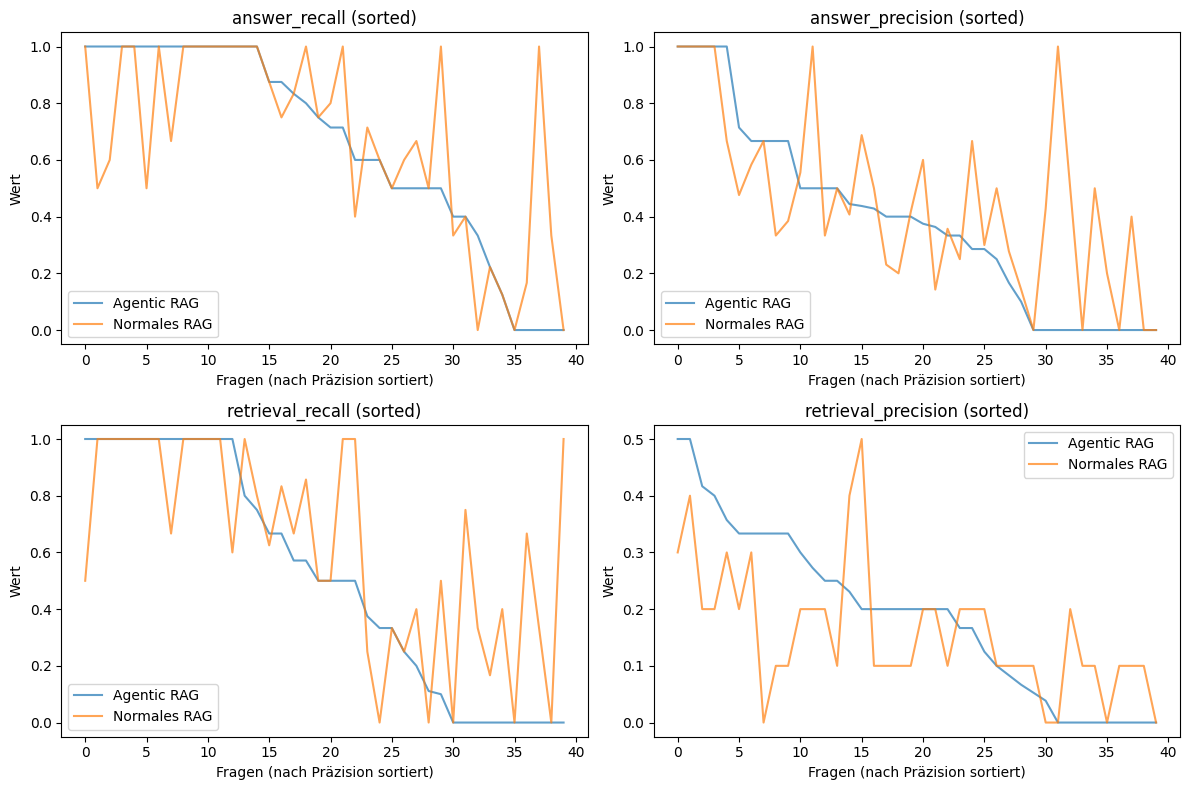

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# import data
df_agentic_rag = pd.read_csv("df_agentic.csv", index_col=False).drop(columns=["Unnamed: 0"])
df_plain_rag   = pd.read_csv("rag_runs/2025-09-09/df_plain_rag.csv", index_col=False).drop(columns=["Unnamed: 0"])

columns = df_agentic_rag.columns  

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]

    # sort both series by agentic metric value (descending)
    order = df_agentic_rag[col].sort_values(ascending=False).index
    agentic_sorted = df_agentic_rag.loc[order, col].reset_index(drop=True)
    plain_sorted   = df_plain_rag.loc[order, col].reset_index(drop=True)

    ax.plot(agentic_sorted.index, agentic_sorted, label="Agentic RAG", alpha=0.7)
    ax.plot(plain_sorted.index, plain_sorted, label="Normales RAG", alpha=0.7)

    ax.set_title(f"{col} (sorted)")
    ax.set_xlabel("Fragen (nach Präzision sortiert)")
    ax.set_ylabel("Wert")
    ax.legend()

plt.tight_layout()
plt.show()

